# Algorithms Performance Analysis

## Configurations Table

| Number | Grid Size | Number of Drones | Drones Initial Positions | Disperse Constant | Time Step Limit | Person Initial Position
| --- | --- | --- | --- | --- | --- | --- |
| 1 | 20x20 | 1 | (0,0) | 3 | 100 | (9,9) |
| 2 | 20x20 | 2 | (0,0), (19, 19) | 3 | 100 | (9,9) |
| 3 | 20x20 | 4 | (0,0), (19, 19), (0, 19), (19, 0) | 3 | 100 | (9,9) |



## Importing Libraries

In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from DSSE.env import DroneSwarmSearch
import concurrent.futures

## Importing Necessary Modules

In [202]:
from config import get_config
from algorithms.reinforce import Reinforce
from algorithms.parallel_sweep import MultipleParallelSweep

## Load Data

In [203]:
def load_data(config_number=0):
    config = get_config(config_number)
    statistics = pd.read_csv(
        f"data/statistics_{config.grid_size}_{config.grid_size}_{config.n_drones}.csv"
    )
    nn = torch.load(
        f"data/nn_{config.grid_size}_{config.grid_size}_{config.n_drones}.pt"
    )

    return statistics, nn

In [204]:
statistics_config_1, nn_config_1 = load_data(1)
statistics_config_2, nn_config_2 = load_data(2)
statistics_config_3, nn_config_3 = load_data(3)

## Plotting Learning Curves

In [214]:
def plot_learning_curve(statistics, num_drones):
    _, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()

    # Plot mean rewards considering a window of 500 episodes
    ax1.plot(
        statistics["episode"],
        statistics["rewards"].rolling(500).mean(),
        "r-",
        label="Mean Rewards",
    )
    ax1.set_ylabel("Mean Rewards")

    # Plot mean actions considering a window of 500 episodes

    # Divide actions by the number of drones to get the mean number of actions per drone
    statistics["actions"] = statistics["actions"] / num_drones

    ax2.plot(
        statistics["episode"],
        statistics["actions"].rolling(500).mean(),
        "b-",
        label="Mean Actions",
    )
    ax2.set_ylabel("Mean Actions")

    # Legend, title and labels
    ax1.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.0)
    ax2.legend(loc="upper right", bbox_to_anchor=(1.235, 0.95), borderaxespad=0.0)
    plt.title(f"Learning Curve - {num_drones} drone")
    ax1.set_xlabel("Episodes")
    plt.grid()
    plt.show()

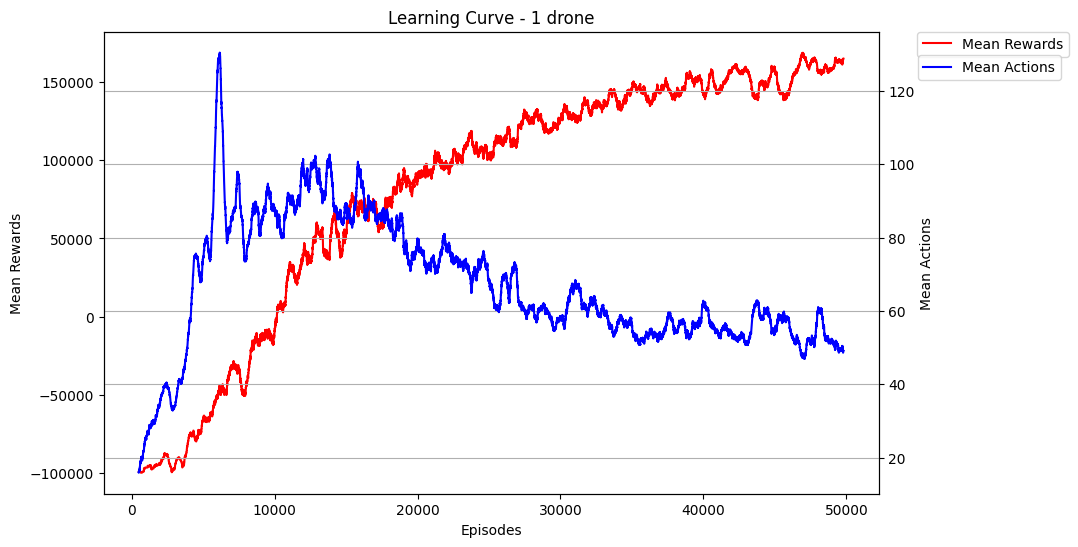

In [215]:
plot_learning_curve(statistics_config_1, 1)

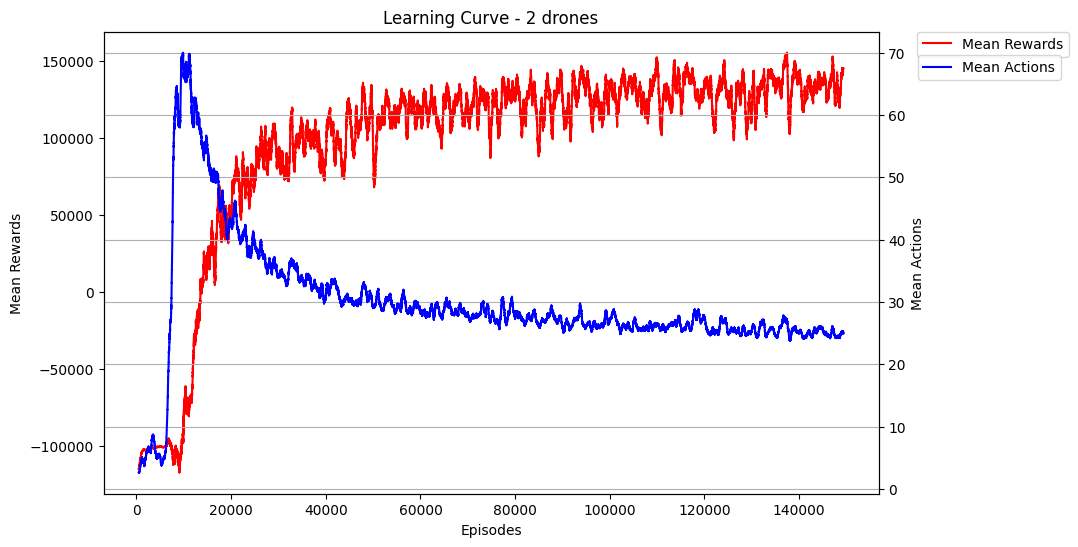

In [207]:
plot_learning_curve(statistics_config_2, 2)

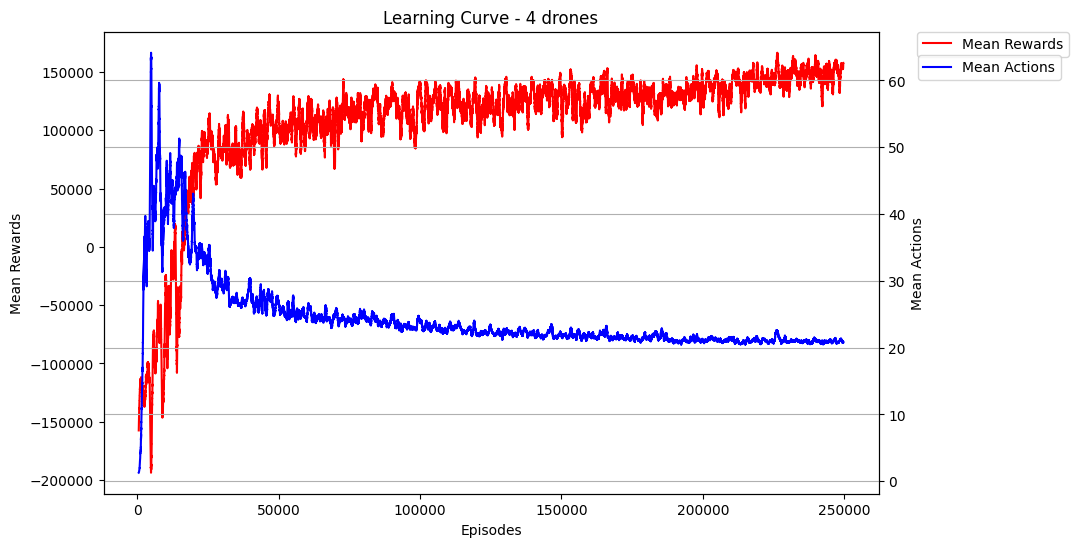

In [208]:
plot_learning_curve(statistics_config_3, 4)

##  Comparing Algorithms

In [209]:
def instantiate_env(config_number=1):
    config = get_config(config_number)
    env = DroneSwarmSearch(
        grid_size=config.grid_size,
        render_mode="ansi",
        render_grid=False,
        render_gradient=False,
        n_drones=config.n_drones,
        person_initial_position=config.person_initial_position,
        disperse_constant=config.disperse_constant,
        timestep_limit=config.timestep_limit,
    )
    return env


def get_random_speed_vector():
    return [
        round(np.random.uniform(-0.1, 0.1), 1),
        round(np.random.uniform(-0.1, 0.1), 1),
    ]


def run_one_episode_reinforce(env, nn, config_number=1):
    config = get_config(config_number)
    reinforce = Reinforce(env=env)
    episode_actions = {}
    state = env.reset(
        drones_positions=config.drones_initial_positions,
        vector=reinforce.get_random_speed_vector(),
    )
    obs_list = reinforce.flatten_state(state)
    steps_count = 0
    total_reward = 0
    done = False

    while not done:
        for drone_index in range(len(env.possible_agents)):
            probs = nn(obs_list[drone_index].float())
            dist = torch.distributions.Categorical(probs)
            episode_actions[f"drone{drone_index}"] = dist.sample().item()

        obs_list_, reward_dict, _, done, info = env.step(episode_actions)
        obs_list = reinforce.flatten_state(obs_list_)
        done = any(done.values())

        total_reward += reward_dict["total_reward"]
        steps_count += 1

    return total_reward, steps_count, info["Found"]


def run_one_episode_parallel_sweep(env, config_number=1):
    config = get_config(config_number)
    env.reset(
        drones_positions=config.drones_initial_positions,
        vector=get_random_speed_vector(),
    )
    algorithm = MultipleParallelSweep(env)
    reward, steps, found = algorithm.run()
    return reward, steps, found

In [210]:
run_one_episode_reinforce(instantiate_env(1), nn_config_1, 1)

(183105.2696605231, 38, True)

In [211]:
run_one_episode_parallel_sweep(instantiate_env(1), 1)

(-100000, 202, False)

In [212]:
def collect_algorithms_data(config_number=1):
    config = get_config(config_number)
    env = instantiate_env(config_number)
    nn = torch.load(
        f"data/nn_{config.grid_size}_{config.grid_size}_{config.n_drones}.pt"
    )

    reinforce_rewards = []
    reinforce_steps = []
    reinforce_found = []
    parallel_sweep_rewards = []
    parallel_sweep_steps = []
    parallel_sweep_found = []

    for i in range(100):
        print(i)
        reward, steps, found = run_one_episode_reinforce(env, nn, config_number)
        reinforce_rewards.append(reward)
        reinforce_steps.append(steps)
        reinforce_found.append(found)
        reward, steps, found = run_one_episode_parallel_sweep(env, config_number)
        parallel_sweep_rewards.append(reward)
        parallel_sweep_steps.append(steps)
        parallel_sweep_found.append(found)

    return (
        reinforce_rewards,
        reinforce_steps,
        reinforce_found,
        parallel_sweep_rewards,
        parallel_sweep_steps,
        parallel_sweep_found,
    )


def plot_box_plot(data, title):
    plt.figure(figsize=(10, 6))
    plt.boxplot(data)
    plt.title(title)
    plt.show()


def pizza_plot(data, title):
    plt.figure(figsize=(10, 6))
    # count how many times the person was found
    data = [data.count(True), data.count(False)]

    plt.pie(data, labels=["Found", "Not Found"], autopct="%1.1f%%")
    plt.title(title)
    plt.show()


def plot_data(config_number=1):
    (
        reinforce_rewards,
        reinforce_steps,
        reinforce_found,
        parallel_sweep_rewards,
        parallel_sweep_steps,
        parallel_sweep_found,
    ) = collect_algorithms_data(config_number)

    plot_box_plot(reinforce_rewards, "Reinforce Rewards")
    plot_box_plot(reinforce_steps, "Reinforce Steps")
    pizza_plot(reinforce_found, "Reinforce Found")

    plot_box_plot(parallel_sweep_rewards, "Parallel Sweep Rewards")
    plot_box_plot(parallel_sweep_steps, "Parallel Sweep Steps")
    pizza_plot(parallel_sweep_found, "Parallel Sweep Found")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


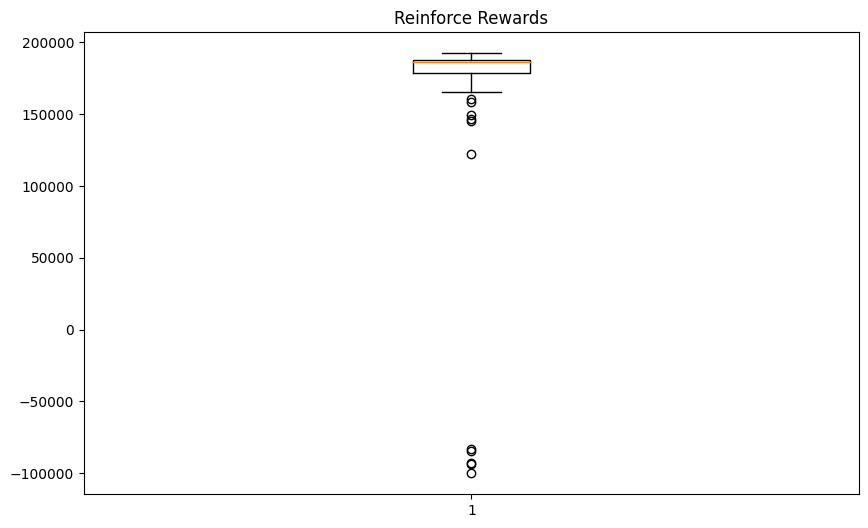

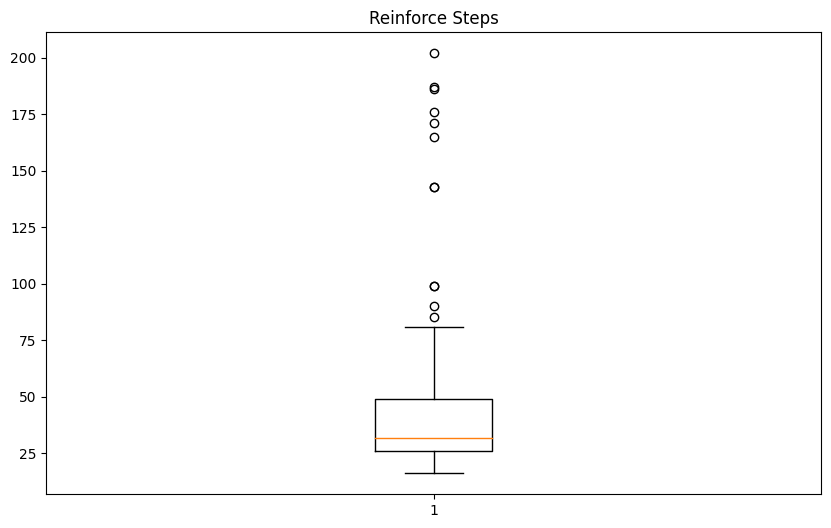

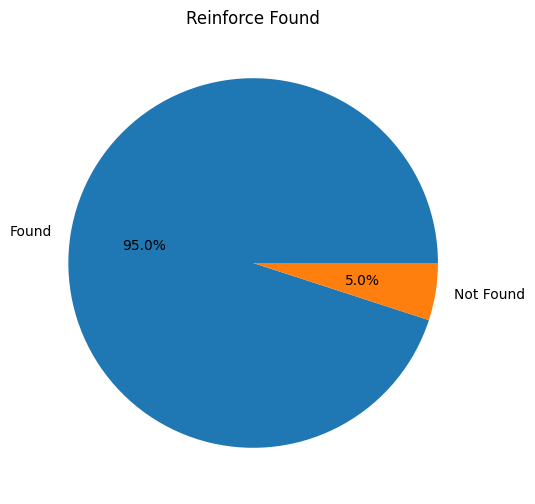

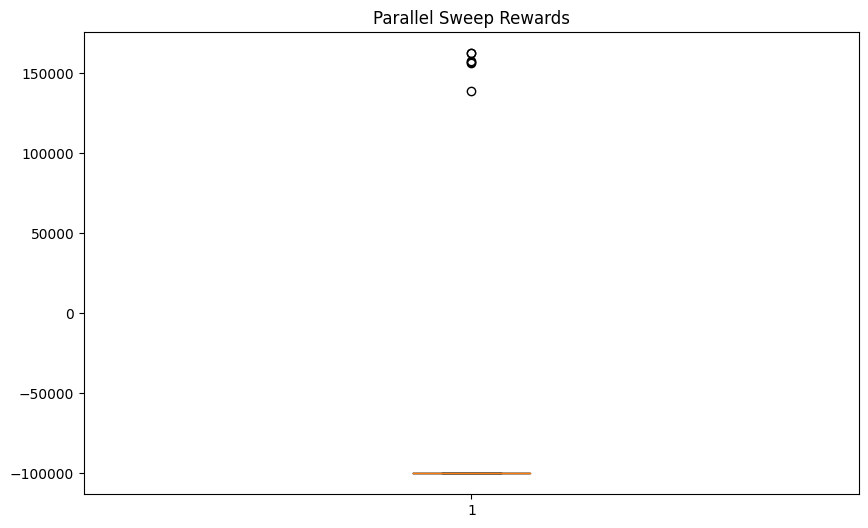

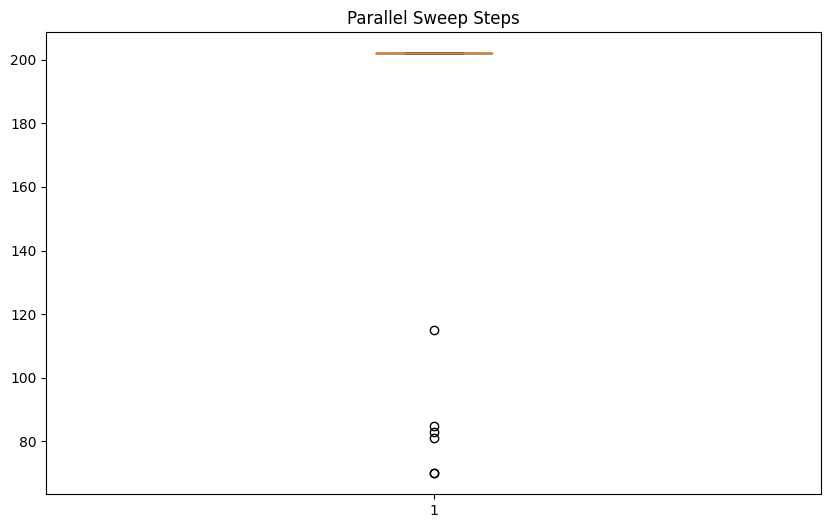

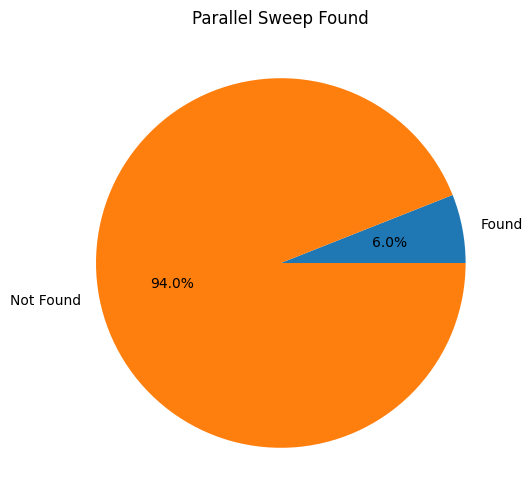

In [213]:
plot_data(1)